In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

def new_engine(dialect, server, database, user=None, password=None, integrated_security=True):
    if integrated_security:
        # For Windows authentication
        eng = f"{dialect}://{server}/{database}?trusted_connection=yes&driver=ODBC+Driver+17+for+SQL+Server"
    else:
        # For SQL Server authentication
        eng = f"{dialect}://{user}:{password}@{server}/{database}?driver=ODBC+Driver+17+for+SQL+Server"
    print(eng)
    return create_engine(eng)

# For Windows authentication
# Replace the server argument with the Server Name found when logging into SQL Server Management Studio 
# OR
# For SQL Server authentication
# Replace the server, user and password argument with the Server Name, username and password
engine = new_engine('mssql', 'TUSAN', 'AdventureWorks2022', integrated_security=True)

In [ ]:
# Graf över anställda och avdelning

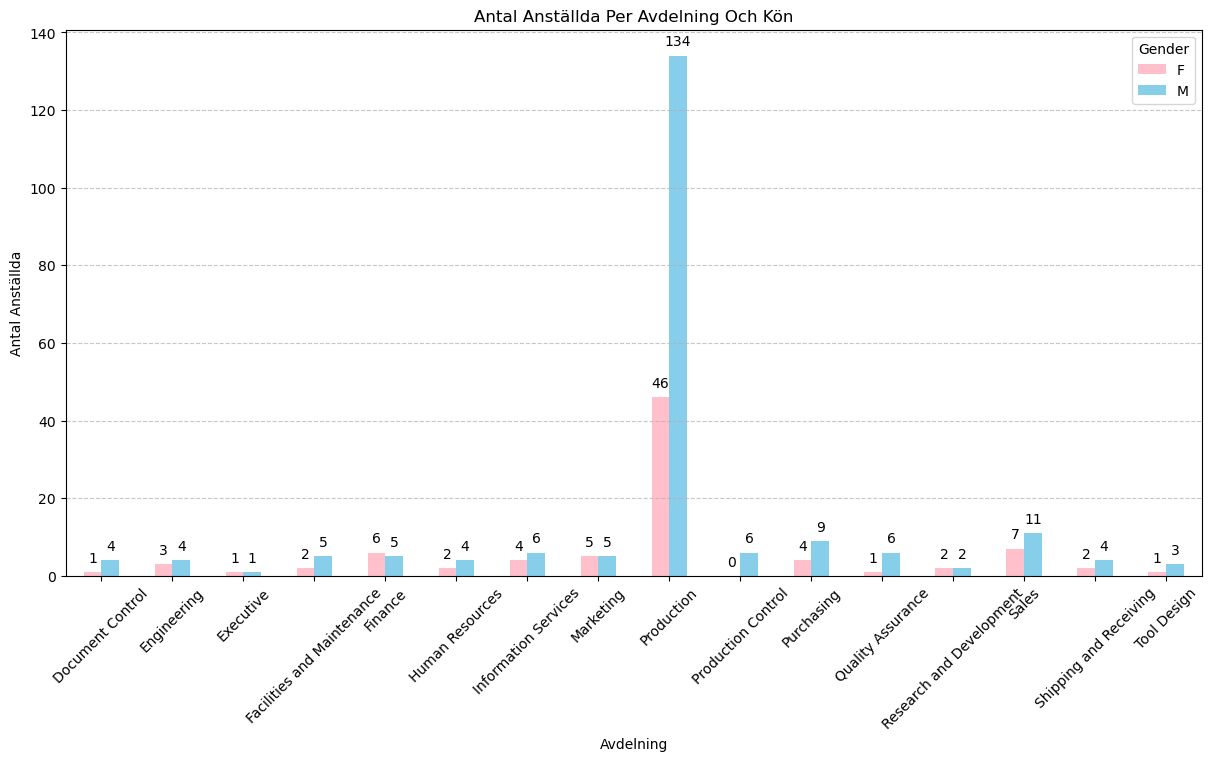

In [62]:
query = """
    SELECT D.Name AS DepartmentName
        , E.Gender
    FROM
        HumanResources.Employee AS E
    INNER JOIN
        HumanResources.EmployeeDepartmentHistory AS EDH ON E.BusinessEntityID = EDH.BusinessEntityID
    INNER JOIN
        HumanResources.Department AS D ON EDH.DepartmentID = D.DepartmentID;
"""

# Hämta data från SQL-databasen
data = pd.read_sql(query, engine)

# Stäng anslutningen till databasen varför? ingen som vet
engine.dispose()

# Skapa ett stapeldiagram för varje kön bredvid varandra per avdelning
fig, ax = plt.subplots(figsize=(12, 7.5), constrained_layout = True)

data_grouped = data.groupby(["DepartmentName", "Gender"]).size().unstack()

data_grouped.plot(kind="bar", ax=ax, width=0.5, position=0.5, color=["pink", "skyblue"])

# Få antal anställda ovanför varje stapel, lånad kod men det är ju programmering. Men använder annotate för att kunna kommentera ovanför varje stapel med en siffra. 
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')


# labels å så 
plt.xlabel("Avdelning")
plt.ylabel("Antal Anställda")
plt.title("Antal Anställda Per Avdelning Och Kön")

ax.tick_params(axis="x", rotation=45, labelsize=10) 
ax.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

In [ ]:
#Graf över sjuktimmar / semestertimmar per avdelning

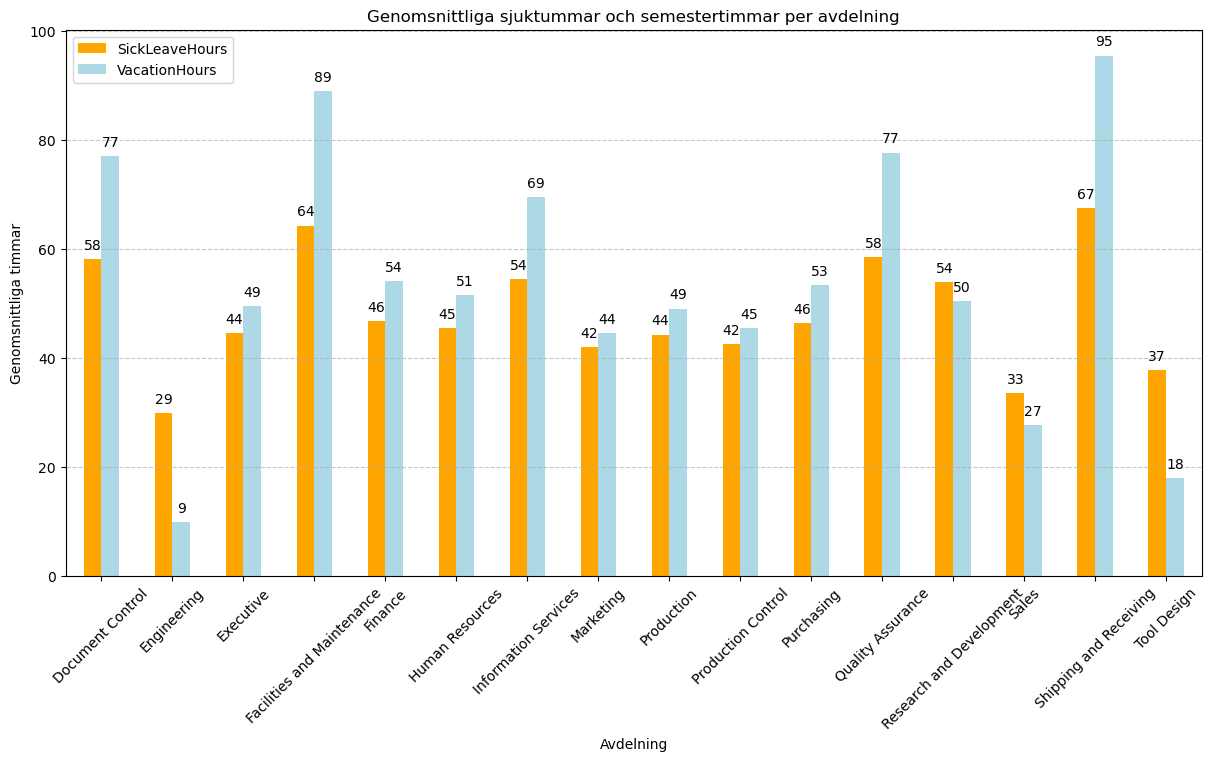

In [56]:

query = """SELECT E.BusinessEntityID
	, E.Gender
	, E.SickLeaveHours
	, E.VacationHours
    , D.DepartmentID
    , D.Name
FROM
    HumanResources.Employee AS E
INNER JOIN
    HumanResources.EmployeeDepartmentHistory AS H ON E.BusinessEntityID = H.BusinessEntityID
INNER JOIN
    HumanResources.Department AS D ON H.DepartmentID = D.DepartmentID
ORDER BY BusinessEntityID;
"""

# Hämta data från SQL-databasen
data = pd.read_sql(query, engine)

# Stäng anslutningen till databasen varför? ingen som vet
engine.dispose()

# Försöka bygga grafen och beräkna genomsnitt för sjuktimmar och vacationhours per avdelning
average_data = data.groupby("Name").agg({"SickLeaveHours": "mean", "VacationHours": "mean"}).reset_index()

fig, ax = plt.subplots(figsize=(12, 7.5), constrained_layout=True)

# plotta 
average_data.plot(kind="bar", x="Name", y=["SickLeaveHours", "VacationHours"], ax=ax, width=0.5, position=0.5, color=["orange", "lightblue"])

# Lägg till text ovanför varje stapel med genomsnittsvärde
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# labels och så
plt.xlabel("Avdelning")
plt.ylabel("Genomsnittliga timmar")
plt.title("Genomsnittliga sjuktummar och semestertimmar per avdelning")

ax.tick_params(axis="x", rotation=45, labelsize=10) 
ax.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# känns dock inte som om detta gör oss något egentligen som går att använda

In [ ]:
# Genomsnittslön per avdelning 

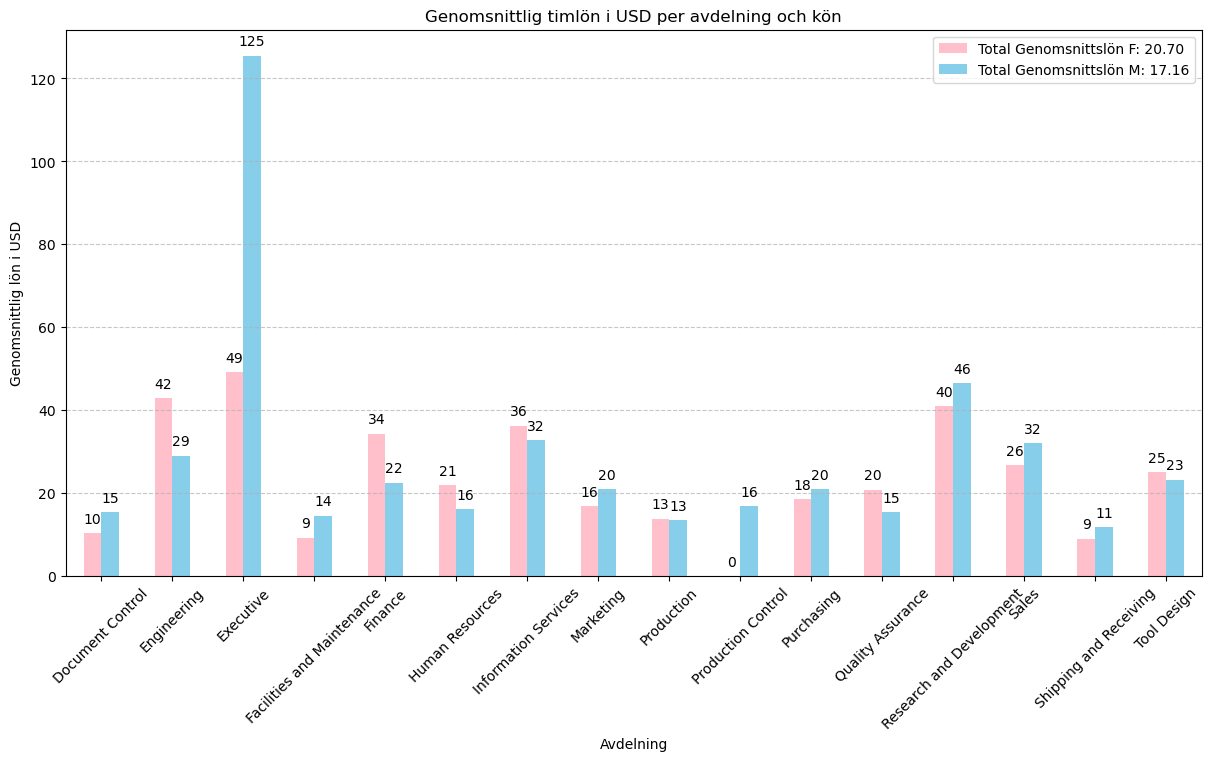

In [57]:
import pandas as pd
import matplotlib.pyplot as plt

query = """SELECT 
    E.BusinessEntityID
    , E.Gender
    , D.DepartmentID
    , D.Name
    , G.Rate
FROM
    HumanResources.Employee AS E
INNER JOIN 
    HumanResources.EmployeePayHistory AS G ON E.BusinessEntityID = G.BusinessEntityID
INNER JOIN 
    HumanResources.EmployeeDepartmentHistory AS H ON E.BusinessEntityID = H.BusinessEntityID
INNER JOIN
    HumanResources.Department AS D ON H.DepartmentID = D.DepartmentID;
"""

# Hämta data från SQL-databasen
data = pd.read_sql(query, engine)

# Stäng anslutningen till databasen
engine.dispose()

# Plotta stapeldiagrammet
average_salary = data.groupby(["Name", "Gender"]).agg({"Rate": "mean"}).reset_index()

fig, ax = plt.subplots(figsize=(12, 7.5), constrained_layout=True)
pivot_data = average_salary.pivot(index="Name", columns="Gender", values="Rate")

pivot_data.plot(kind="bar", ax=ax, width=0.5, position=0.5, color=["pink", "skyblue"])

# Lägg till total genomsnittslön för män och kvinnor i legenden
medel = data.groupby("Gender")["Rate"].mean()
legend_labels = [f"Total Genomsnittslön {gender}: {mean:.2f}" for gender, mean in medel.items()]
ax.legend(legend_labels, loc="upper right")

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    
# labels och så
ax.set_xlabel("Avdelning")
ax.set_ylabel("Genomsnittlig lön i USD")
ax.set_title("Genomsnittlig timlön i USD per avdelning och kön")

ax.tick_params(axis="x", rotation=45, labelsize=10) 
ax.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()



In [ ]:
# Tvåsidig graf med genomsnittslön/kön och ålder

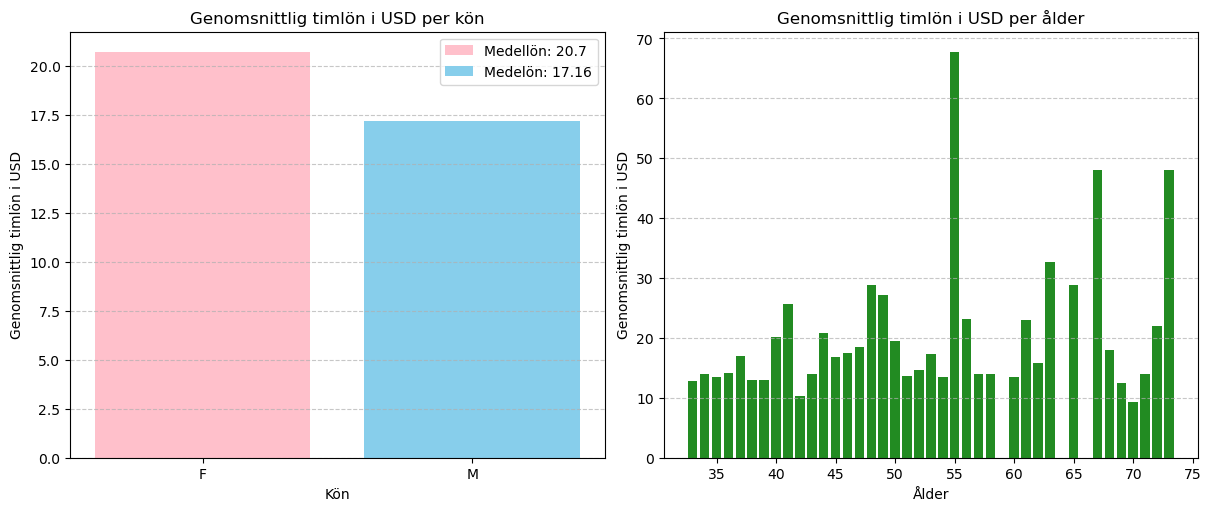

In [58]:
import pandas as pd
import matplotlib.pyplot as plt

# TVEKSAMT OM DENNA KOMMER ANVÄNDAS
query = """
    SELECT 
        E.BusinessEntityID
        , E.Gender
        , G.Rate
        , DATEDIFF(YEAR, BirthDate, GETDATE()) AS Age
    FROM
        HumanResources.Employee AS E
    INNER JOIN 
        HumanResources.EmployeePayHistory AS G ON E.BusinessEntityID = G.BusinessEntityID
    INNER JOIN 
        HumanResources.EmployeeDepartmentHistory AS H ON E.BusinessEntityID = H.BusinessEntityID
"""

# Hämta data från SQL-databasen
data = pd.read_sql(query, engine)

# Stäng anslutningen till databasen
engine.dispose()

# Gruppera data efter kön/ålder och beräkna genomsnittslönen
average_gender = data.groupby("Gender").agg({"Rate": "mean"}).reset_index()

average_age = data.groupby("Age").agg({"Rate": "mean"}).reset_index()

# Skapa två grafer sida vid sida
fig, ax = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

# Graf per kön
bars_gender = ax[0].bar(average_gender["Gender"], average_gender["Rate"], color=["pink", "skyblue"])
ax[0].set_title("Genomsnittlig timlön i USD per kön")
ax[0].set_xlabel("Kön")
ax[0].set_ylabel("Genomsnittlig timlön i USD")
ax[0].grid(axis="y", linestyle="--", alpha=0.7)

# Använd annotate för att placera avrundade siffror för genomsnittslönen i vänstra baren i legenden
avg_rounded_gender = average_gender["Rate"].round(2)
ax[0].legend([bars_gender[0], bars_gender[1]], [f"Medellön: {avg_rounded_gender[0]}", f"Medelön: {avg_rounded_gender[1]}"])

# Graf för genomsnittslön per ålder
bars_age = ax[1].bar(average_age["Age"], average_age["Rate"], color="forestgreen")
ax[1].set_title("Genomsnittlig timlön i USD per ålder")
ax[1].set_xlabel("Ålder")
ax[1].set_ylabel("Genomsnittlig timlön i USD")
ax[1].grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


In [ ]:
# Månadsvis inkomst

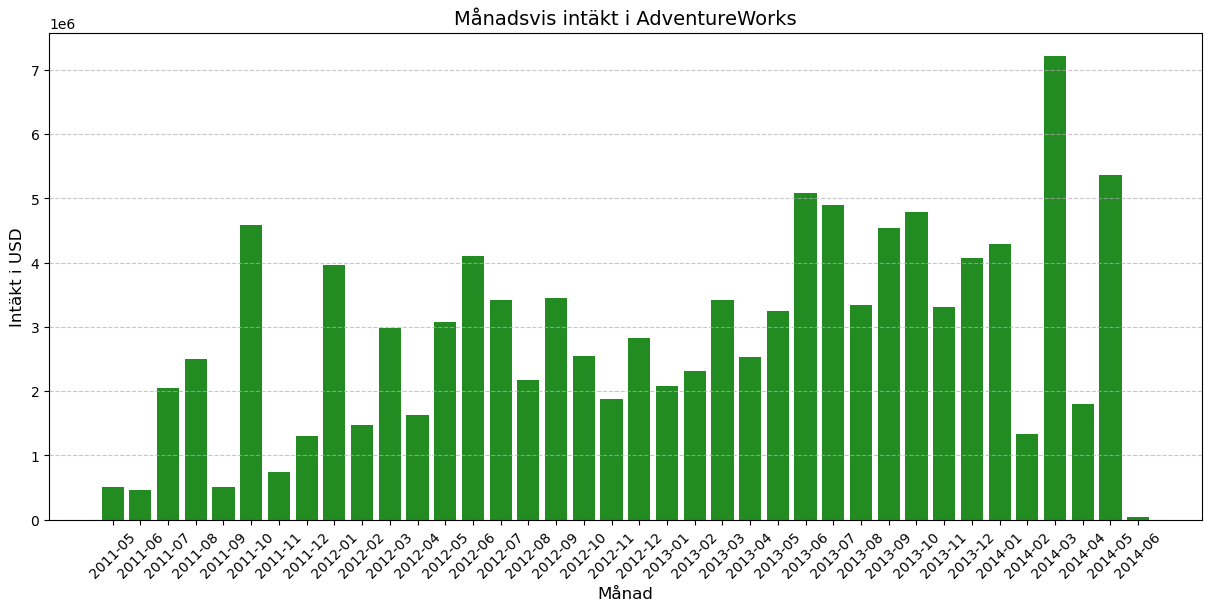

In [64]:
query = """
    SELECT 
        FORMAT(OrderDate, 'yyyy-MM') AS SalesMonth
        , SUM(SubTotal) AS Revenue
    FROM 
        Sales.SalesOrderHeader
    GROUP BY 
        FORMAT(OrderDate, 'yyyy-MM')
    ORDER BY 
        SalesMonth;
"""


# Hämta data från SQL-databasen
data = pd.read_sql(query, engine)

# Stäng anslutningen till databasen
engine.dispose()

# plotta
fig, ax = plt.subplots(figsize=(12, 6), constrained_layout=True)
ax.bar(data["SalesMonth"], data["Revenue"], color="forestgreen")

ax.set_xlabel("Månad", fontsize=12)
ax.set_ylabel("Intäkt i USD", fontsize=12)
ax.set_title("Månadsvis intäkt i AdventureWorks", fontsize=14)

ax.tick_params(axis="x", rotation=45, labelsize=10) 
ax.grid(axis="y", linestyle="--", alpha=0.7)

# Visa diagrammet
plt.show()


In [ ]:
# Fin graf med försäljning per månad och region

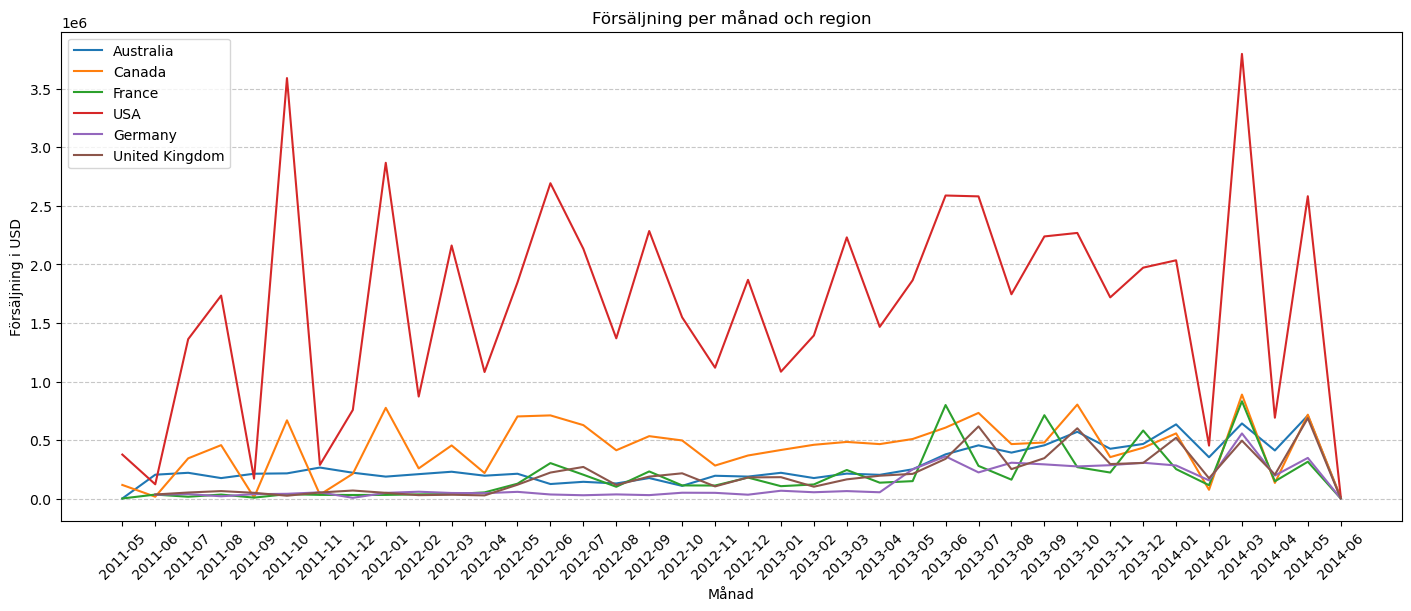

In [63]:
query = """
    SELECT 
    FORMAT(soh.OrderDate, 'yyyy-MM') AS SalesMonth,
    CASE 
        WHEN st.TerritoryID IN (1, 2, 3, 4, 5) THEN 'USA'
        ELSE st.Name 
    END AS Territory,
    SUM(soh.SubTotal) AS Revenue
FROM 
    Sales.SalesOrderHeader AS soh
INNER JOIN 
    Sales.SalesTerritory AS st ON soh.TerritoryID = st.TerritoryID
GROUP BY 
    FORMAT(soh.OrderDate, 'yyyy-MM'),
    CASE 
        WHEN st.TerritoryID IN (1, 2, 3, 4, 5) THEN 'USA'
        ELSE st.Name 
    END
ORDER BY 
    SalesMonth,
    Territory;
"""
# Hämta data från SQL-databasen
data = pd.read_sql(query, engine)

# Stäng anslutningen till databasen
engine.dispose()

fig, ax = plt.subplots(figsize=(14, 6), constrained_layout=True)

# Loopa igenom varje territorium och plotta försäljningen över månader
for territory in data["Territory"].unique():
    variabel = data[data["Territory"] == territory]
    ax.plot(variabel["SalesMonth"], variabel["Revenue"], label=territory)

# labels och så
ax.set_xlabel("Månad")
ax.set_ylabel("Försäljning i USD")
ax.set_title("Försäljning per månad och region")
ax.legend()

ax.tick_params(axis="x", rotation=45, labelsize=10) 
ax.grid(axis="y", linestyle="--", alpha=0.7)


# Visa diagrammet
plt.show()


In [ ]:
# Graf på försäljning med och utan säsongsrabatten

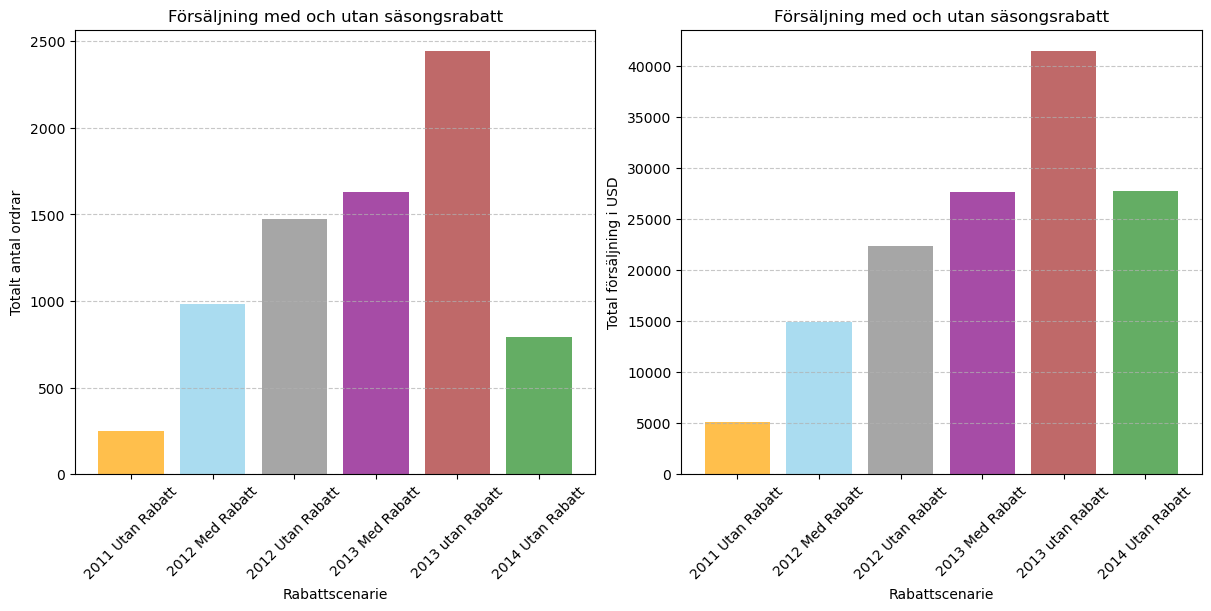

In [66]:
import matplotlib.pyplot as plt
import numpy as np


#2012 med enbart rabatt
query12rabatt= """
SELECT
    sod.UnitPrice
    , SUM(sod.OrderQty) AS TotalOrderQty
    , SUM(sod.LineTotal) AS TotalLineTotal
FROM 
    Sales.SpecialOffer AS so 
INNER JOIN 
    Sales.SpecialOfferProduct AS sop ON so.SpecialOfferID = sop.SpecialOfferID
INNER JOIN 
    Sales.SalesOrderDetail AS sod ON sop.ProductID = sod.ProductID
INNER JOIN 
    Sales.SalesOrderHeader AS soh ON sod.SalesOrderID = soh.SalesOrderID
WHERE (sop.ProductID IN ('707', '708', '711'))
    AND (so.SpecialOfferID IN ('11', '8'))
    AND (soh.OrderDate >= '2012-05-30' AND soh.OrderDate < '2012-06-29')
GROUP BY
    sod.UnitPrice
"""

# 2013 sälj enbart rabatt 
query13rabatt = """	
SELECT
    sod.UnitPrice
    , SUM(sod.OrderQty) AS TotalOrderQty
    , SUM(sod.LineTotal) AS TotalLineTotal
FROM 
    Sales.SpecialOffer AS so 
INNER JOIN 
    Sales.SpecialOfferProduct AS sop ON so.SpecialOfferID = sop.SpecialOfferID
INNER JOIN 
    Sales.SalesOrderDetail AS sod ON sop.ProductID = sod.ProductID
INNER JOIN 
    Sales.SalesOrderHeader AS soh ON sod.SalesOrderID = soh.SalesOrderID
WHERE (sop.ProductID IN ('707', '708', '711'))
    AND (so.SpecialOfferID IN ('11', '8'))
    AND (soh.OrderDate >= '2013-05-30' AND soh.OrderDate < '2013-06-29')
GROUP BY
    sod.UnitPrice
"""

# 2012 utan säsongsrabatt
query12utan= """
SELECT
    sod.UnitPrice
    , SUM(sod.OrderQty) AS TotalOrderQty
    , SUM(sod.LineTotal) AS TotalLineTotal
FROM 
    Sales.SpecialOffer AS so 
INNER JOIN 
    Sales.SpecialOfferProduct AS sop ON so.SpecialOfferID = sop.SpecialOfferID
INNER JOIN 
    Sales.SalesOrderDetail AS sod ON sop.ProductID = sod.ProductID
INNER JOIN 
    Sales.SalesOrderHeader AS soh ON sod.SalesOrderID = soh.SalesOrderID
WHERE (sop.ProductID IN ('707', '708', '711'))
    AND (so.SpecialOfferID <> '11' AND so.SpecialOfferID <> '8')
    AND (soh.OrderDate >= '2012-05-30' AND soh.OrderDate < '2012-06-29')
GROUP BY
    sod.UnitPrice
"""

#2013 utan säsonsrabatt 

query13utan = """	
SELECT
    sod.UnitPrice
    , SUM(sod.OrderQty) AS TotalOrderQty
    , SUM(sod.LineTotal) AS TotalLineTotal
FROM 
    Sales.SpecialOffer AS so 
INNER JOIN 
    Sales.SpecialOfferProduct AS sop ON so.SpecialOfferID = sop.SpecialOfferID
INNER JOIN 
    Sales.SalesOrderDetail AS sod ON sop.ProductID = sod.ProductID
INNER JOIN 
    Sales.SalesOrderHeader AS soh ON sod.SalesOrderID = soh.SalesOrderID
WHERE (sop.ProductID IN ('707', '708', '711'))
    AND (so.SpecialOfferID <> '11' AND so.SpecialOfferID <> '8')
    AND (soh.OrderDate >= '2013-05-30' AND soh.OrderDate < '2013-06-29')
GROUP BY
    sod.UnitPrice
"""


#-- summa å qty 2011 UTAN rabatt
#2011 UTAN RABATT
query11 = """
SELECT 
    sod.UnitPrice
    , SUM(sod.OrderQty) AS TotalOrderQty
    , SUM(sod.LineTotal) AS TotalLineTotal
FROM 
    Sales.SpecialOffer AS so 
INNER JOIN 
    Sales.SpecialOfferProduct AS sop ON so.SpecialOfferID = sop.SpecialOfferID
INNER JOIN 
    Sales.SalesOrderDetail AS sod ON sop.ProductID = sod.ProductID
INNER JOIN 
    Sales.SalesOrderHeader AS soh ON sod.SalesOrderID = soh.SalesOrderID
WHERE (sop.ProductID IN ('707', '708', '711'))
    AND (so.SpecialOfferID <> '11' AND so.SpecialOfferID <> '8')
    AND (soh.OrderDate >= '2011-05-30' AND soh.OrderDate < '2011-06-29')
GROUP BY
    sod.UnitPrice

"""

# 2014 UTAN RABATT
query14 = """ SELECT
    sod.UnitPrice
    , SUM(sod.OrderQty) AS TotalOrderQty
    , SUM(sod.LineTotal) AS TotalLineTotal
FROM 
    Sales.SpecialOffer AS so 
INNER JOIN 
    Sales.SpecialOfferProduct AS sop ON so.SpecialOfferID = sop.SpecialOfferID
INNER JOIN 
    Sales.SalesOrderDetail AS sod ON sop.ProductID = sod.ProductID
INNER JOIN 
    Sales.SalesOrderHeader AS soh ON sod.SalesOrderID = soh.SalesOrderID
WHERE (sop.ProductID IN ('707', '708', '711'))
    AND (so.SpecialOfferID <> '11' AND so.SpecialOfferID <> '8')
    AND (soh.OrderDate >= '2014-05-30' AND soh.OrderDate < '2014-06-29')
GROUP BY
    sod.UnitPrice
    """


utan12 = pd.read_sql(query12utan, engine)
med12 = pd.read_sql(query12rabatt, engine)
utan13 = pd.read_sql(query13utan, engine)
med13 = pd.read_sql(query13rabatt, engine)
utan11 = pd.read_sql(query11, engine)
utan14 = pd.read_sql(query14, engine)

engine.dispose()

import matplotlib.pyplot as plt
import pandas as pd


# skapa variabeln
resultat_per_period = pd.concat([utan11, med12, utan12, med13, utan13, utan14], ignore_index=True)

# plotta tvåsidigt
fig, ax = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)

# Orderqty
ax1 = ax[0].bar(["2011 Utan Rabatt", "2012 Med Rabatt", "2012 Utan Rabatt", "2013 Med Rabatt", "2013 utan Rabatt", "2014 Utan Rabatt"],
       [utan11["TotalOrderQty"].sum(), med12["TotalOrderQty"].sum(), utan12["TotalOrderQty"].sum(), med13["TotalOrderQty"].sum(), utan13["TotalOrderQty"].sum(), utan14["TotalOrderQty"].sum()],
       label="Antal ordrar", color=["orange", "skyblue", "gray", "purple", "brown", "forestgreen"], alpha=0.7)

# Linetotal
ax2 = ax[1].bar(["2011 Utan Rabatt", "2012 Med Rabatt", "2012 Utan Rabatt", "2013 Med Rabatt", "2013 utan Rabatt", "2014 Utan Rabatt"],
       [utan11["TotalLineTotal"].sum(), med12["TotalLineTotal"].sum(), utan12["TotalLineTotal"].sum(), med13["TotalLineTotal"].sum(), utan13["TotalLineTotal"].sum(), utan14["TotalLineTotal"].sum()],
       label='Total försäljning i USD', color=["orange", "skyblue", "gray", "purple", "brown", "forestgreen"], alpha=0.7)

# Justera etiketter och titel
ax[0].set_xlabel("Rabattscenarie")
ax[0].set_ylabel("Totalt antal ordrar")
ax[0].set_title("Försäljning med och utan säsongsrabatt")
ax[0].tick_params(axis="x", rotation=45, labelsize=10) 
ax[0].grid(axis="y", linestyle="--", alpha=0.7)

ax[1].set_xlabel("Rabattscenarie")
ax[1].set_ylabel("Total försäljning i USD")
ax[1].set_title("Försäljning med och utan säsongsrabatt")
ax[1].tick_params(axis="x", rotation=45, labelsize=10) 
ax[1].grid(axis="y", linestyle="--", alpha=0.7)


# Lägg till enhetspris i legend
#ax[0].legend([ax1], ['Unit Price'], loc='upper left')
#ax[1].legend([ax2], ['Unit Price'], loc='upper left')

# Visa diagrammet
plt.show()


In [ ]:
# Statistisk analys på projiceringen för 2014 med konfidensintervall

# simpelt och lånat histogram

Konfidensintervall för försäljning 2013 med rabatt: (-253.18037157432946, 1883.1803715743295)
Konfidensintervall för försäljning 2013 utan rabatt: (-379.7705573614942, 2824.770557361494)
Projicerat konfidensintervall för extra försäljning 2014 med rabatt: (-245.8312853568932, 1843.1389772994708)


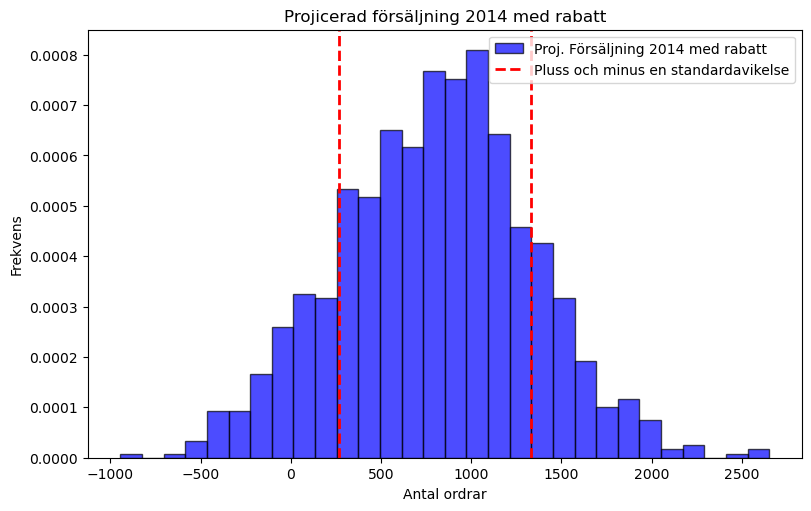

In [82]:
import pandas as pd
import numpy as np
import scipy as sp
from scipy.stats import norm

# Göra konfidensintervall för att killgissa på hur 2014s försäljning kunde ha sett ut ifall dom hade haft kvar rabatten
# 2013 sälj enbart rabatt 
query13rabatt = """	
SELECT
    sod.UnitPrice
    , SUM(sod.OrderQty) AS TotalOrderQty
    , SUM(sod.LineTotal) AS TotalLineTotal
FROM 
    Sales.SpecialOffer AS so 
INNER JOIN 
    Sales.SpecialOfferProduct AS sop ON so.SpecialOfferID = sop.SpecialOfferID
INNER JOIN 
    Sales.SalesOrderDetail AS sod ON sop.ProductID = sod.ProductID
INNER JOIN 
    Sales.SalesOrderHeader AS soh ON sod.SalesOrderID = soh.SalesOrderID
WHERE (sop.ProductID IN ('707', '708', '711'))
    AND (so.SpecialOfferID IN ('11', '8'))
    AND (soh.OrderDate >= '2013-05-30' AND soh.OrderDate < '2013-06-29')
GROUP BY
    sod.UnitPrice
"""
# 2013 försäljning utan rabatten (som ej skulle finnas)
query13utan = """	
SELECT
    sod.UnitPrice
    , SUM(sod.OrderQty) AS TotalOrderQty
    , SUM(sod.LineTotal) AS TotalLineTotal
FROM 
    Sales.SpecialOffer AS so 
INNER JOIN 
    Sales.SpecialOfferProduct AS sop ON so.SpecialOfferID = sop.SpecialOfferID
INNER JOIN 
    Sales.SalesOrderDetail AS sod ON sop.ProductID = sod.ProductID
INNER JOIN 
    Sales.SalesOrderHeader AS soh ON sod.SalesOrderID = soh.SalesOrderID
WHERE (sop.ProductID IN ('707', '708', '711'))
    AND (so.SpecialOfferID <> '11' AND so.SpecialOfferID <> '8')
    AND (soh.OrderDate >= '2013-05-30' AND soh.OrderDate < '2013-06-29')
GROUP BY
    sod.UnitPrice
"""

utan13 = pd.read_sql(query13utan, engine)
med13 = pd.read_sql(query13rabatt, engine)

# Beräkna medelvärde
medel_med13 = np.mean(med13["TotalOrderQty"])
medel_utan13 = np.mean(utan13["TotalOrderQty"])


# Beräknad standard deviation
dev_med13 = np.std(med13["TotalOrderQty"])
dev_utan13 = np.std(utan13["TotalOrderQty"])


# Skapa konfidensintervall på informationen vi har

ki_med13 = norm.interval(0.95, loc=medel_med13, scale=dev_med13)
ki_utan13 = norm.interval(0.95, loc=medel_utan13, scale=dev_utan13)

# Slumpa fram försäljningen 2014 med rabatt vad vi hade från 2013 
proj_med14 = np.random.normal(loc=medel_med13, scale=dev_med13, size=1000)

dev_proj_med14 = np.std(proj_med14)


# Skapa konfidensintervall på vårat framslumpade variabel

ki_proj_med14 = norm.interval(0.95, loc=np.mean(proj_med14), scale=np.std(proj_med14))


# Få ut informationen
print("Konfidensintervall för försäljning 2013 med rabatt:", ki_med13)
print("Konfidensintervall för försäljning 2013 utan rabatt:", ki_utan13)
print("Projicerat konfidensintervall för extra försäljning 2014 med rabatt:", ki_proj_med14)


fig, ax = plt.subplots(figsize=(8, 5), constrained_layout=True)


plt.hist(proj_med14, bins=30, density=True, alpha=0.7, color='blue', edgecolor='black', label='Proj. Försäljning 2014 med rabatt')

# Rita standardavvikelsen som en vertikal linje
plt.axvline(np.mean(proj_med14) + dev_proj_med14, color='red', linestyle='dashed', linewidth=2, label='Pluss och minus en standardavikelse')
plt.axvline(np.mean(proj_med14) - dev_proj_med14, color='red', linestyle='dashed', linewidth=2, )

# Lägg till etiketter och titlar
plt.xlabel('Antal ordrar')
plt.ylabel('Frekvens')
plt.title('Projicerad försäljning 2014 med rabatt')
plt.legend()

# Visa histogrammet
plt.show()




In [53]:
# Räkna ut hur många procent av intäckterna kommer från USA 
query = """ SELECT 
    CASE 
		WHEN st.TerritoryID IN (1, 2, 3, 4, 5) THEN 'USA'
        ELSE st.Name 
    END AS Territory,
    SUM(soh.SubTotal) AS Revenue
FROM 
    Sales.SalesOrderHeader AS soh
INNER JOIN 
    Sales.SalesTerritory AS st ON soh.TerritoryID = st.TerritoryID
GROUP BY 
        CASE 
        WHEN st.TerritoryID IN (1, 2, 3, 4, 5) THEN 'USA'
        ELSE st.Name 
    END
ORDER BY 
	Territory;
"""
# Hämta data från SQL-databasen
data = pd.read_sql(query, engine)

# Stäng anslutningen till databasen
engine.dispose()

data["Percentage"] = (data["Revenue"] / data["Revenue"].sum()) * 100
print(data)


        Territory       Revenue  Percentage
0       Australia  1.065534e+07    9.700216
1          Canada  1.635577e+07   14.889676
2          France  7.251556e+06    6.601543
3         Germany  4.915408e+06    4.474802
4  United Kingdom  7.670721e+06    6.983135
5             USA  6.299759e+07   57.350629


In [ ]:
# Kodsnips från SQL för hämtad data 

In [ ]:
# MEST SÅLDA PRODUKT 
SELECT 
    p.ProductID
    , p.Name AS ProductName
    , SUM(sod.OrderQty) AS TotalOrderQty
FROM 
    Sales.SalesOrderDetail AS sod
INNER JOIN 
    Production.Product AS p ON sod.ProductID = p.ProductID
GROUP BY 
    p.ProductID, p.Name
ORDER BY 
    TotalOrderQty DESC

#  Tjänat mest på
SELECT 
    p.ProductID
    , p.Name AS ProductName
    , SUM(sod.LineTotal) AS TotalRevenue
FROM 
    Sales.SalesOrderDetail AS sod
INNER JOIN 
    Production.Product AS p ON sod.ProductID = p.ProductID
GROUP BY 
    p.ProductID
	, p.Name
ORDER BY 
    TotalRevenue DESC


In [ ]:
# kolla på hur mycket det har sålts för per år 
SELECT 
    FORMAT(soh.OrderDate, 'yyyy') AS SalesYear,
    CASE 
        WHEN st.TerritoryID IN (1, 2, 3, 4, 5) THEN 'USA'
        ELSE st.Name 
    END AS Territory,
    SUM(soh.SubTotal) AS Revenue
FROM 
    Sales.SalesOrderHeader AS soh
INNER JOIN 
    Sales.SalesTerritory AS st ON soh.TerritoryID = st.TerritoryID
GROUP BY 
    FORMAT(soh.OrderDate, 'yyyy'),
    CASE 
        WHEN st.TerritoryID IN (1, 2, 3, 4, 5) THEN 'USA'
        ELSE st.Name 
    END
ORDER BY 
    SalesYear,
    Territory;


# Kolla på hur mycket det har sålts totalt under denna fyra års period

SELECT 
    CASE 
		WHEN st.TerritoryID IN (1, 2, 3, 4, 5) THEN 'USA'
        ELSE st.Name 
    END AS Territory,
    SUM(soh.SubTotal) AS Revenue
FROM 
    Sales.SalesOrderHeader AS soh
INNER JOIN 
    Sales.SalesTerritory AS st ON soh.TerritoryID = st.TerritoryID
GROUP BY 
        CASE 
        WHEN st.TerritoryID IN (1, 2, 3, 4, 5) THEN 'USA'
        ELSE st.Name 
    END
ORDER BY 
	Territory;

In [ ]:
# Få fram information om sälj på 3 olika cykelhjälmar dom har seasonalkampanj på och kolla om dom säljer mer under kampanjen eller ej

SELECT so.SpecialOfferID
    , so.Description
    , sop.ProductID
    , sod.SalesOrderID
	, sod.SalesOrderDetailID
    , sod.OrderQty
	, sod.UnitPrice
    , sod.LineTotal
	, soh.OrderDate
FROM 
    Sales.SpecialOffer AS so 
INNER JOIN 
    Sales.SpecialOfferProduct AS sop ON so.SpecialOfferID = sop.SpecialOfferID
INNER JOIN 
    Sales.SalesOrderDetail AS sod ON sop.ProductID = sod.ProductID
INNER JOIN 
    Sales.SalesOrderHeader AS soh ON sod.SalesOrderID = soh.SalesOrderID
WHERE (sop.ProductID = '707' OR sop.ProductID = '708' OR sop.ProductID = '711')
    AND (so.SpecialOfferID = '11' OR so.SpecialOfferID = '8' OR so.SpecialOfferID = '1');

In [ ]:
# Få fram deras kampanjer och även då start och enddate visas här 
SELECT *
FROM Sales.SpecialOffer

